In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn import linear_model
# from sklearn.metrics import mean_squared_error, r2_score
# import statsmodels.api as sm
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import motifs
from Bio.SeqUtils import GC
import math
from scipy.optimize import curve_fit
from scipy.stats import gamma, poisson, nbinom, binom
# from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelmin
from scipy.misc import factorial
import numpy as np
from sklearn.decomposition import PCA
# from statsmodels.discrete.discrete_model import NegativeBinomial


Populating the interactive namespace from numpy and matplotlib


In [2]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [3]:
def callEssentiality(genes_df,genomeLen,pool_dropped_df):
#     This function takes a information about the each gene, the lenght of the genome, and the
#     insertions present. This function then makes a naive assumpion about the insertion rate, 
#     and calculates a preliminary essential gene set. A regression model is then trained using
#     gene length, GC content, and gene position. Finaly, an expected insertion rate is estimated
#     on a gene by gene basis and the likelyhood of essentility is re-estimated

#     add additional columns to gene dataframe to hold intermediate values
    genes_df['pvalInitial'] = [0]*len(genes_df)
    genes_df['length'] = [0]*len(genes_df)
    genes_df['inserts'] = [0]*len(genes_df)
    
#     calculate a naive estimate of insertion rate from the length of the genome 
#     and the total number of insertions
    rate = len(pool_dropped_df)/genomeLen
    print('Predicted rate of insertion: %s' % rate)
    
#     Determining probability that each gene has too few insertions from the binomial distribution
    
#     iterate through the genes in genes_df
    for gene in genes_df.itertuples():
        
#     calculate important charecteristics for the genes
        start = min(gene.begin,gene.end)
        end = max(gene.begin,gene.end)
        length = end-start
        inserts = len(pool_dropped_df[(pool_dropped_df.pos>start) & (pool_dropped_df.pos<end)])
        
#     given the naive assumptions, how likely are you to get the observed number of insertions or less
#     by chance
        pval = binom.cdf(inserts, length, rate)

#     update the gene with the new charecteristics
        genes_df.iloc[gene.Index, genes_df.columns.get_loc('pvalInitial')]=pval
        genes_df.iloc[gene.Index, genes_df.columns.get_loc('length')]=length
        genes_df.iloc[gene.Index, genes_df.columns.get_loc('inserts')]=inserts
    
#     calculate the percentage of essential genes and make lists of the hits and those unlikely to be hits
    print('percent of genes initially called as essential: %s'%
      str(sum(genes_df['pvalInitial']<(0.05/len(genes_df)))/len(genes_df)))
    sigs = genes_df[genes_df['pvalInitial']<(0.05/len(genes_df))]
    neg = genes_df[genes_df['pvalInitial']>=(0.05/len(genes_df))]
    
#     plot the possible essential genes
    fig = plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.scatter(sigs.length, sigs.inserts, c='g',label='essential')
    plt.scatter(neg.length, neg.inserts, c='m',label='nonessential')
    plt.legend(loc=0)
    plt.title('naive essentiality calls')
    plt.ylabel('Insertions')
    plt.xlabel('Length')

    plt.subplot(2,1,2)
    plt.scatter(sigs.GC, sigs.inserts/sigs.length, c='g',label='essential', alpha=0.6, zorder=10)
    plt.scatter(neg.GC, neg.inserts/neg.length, c='m',label='nonessential', alpha=0.6, zorder=1)
    plt.legend(loc=0)
    plt.title('naive essentiality calls')
    plt.ylabel('Insertions')
    plt.xlabel('GC Content')
    plt.show()
    
# #     regress the nonessential genes to predict insertion number from charecteristics
#     X = neg[['length','begin','GC']]
#     y = neg['inserts']

#     reg = linear_model.LassoLarsCV(fit_intercept=False,cv=5)
#     reg.fit(X,y)
    
    
#     print('Coeficients- Length: %s, Position: %s, GC: %s' % (
#         str(reg.coef_[0]),str(reg.coef_[1]),str(reg.coef_[2])))
#     print('Intercept: %s' % str(reg.intercept_))
#     print('Alpha: %s' % str(reg.alpha_))


#     print('Rsquare: %s' % str(reg.score(X,y)))

#     print()
#     print()
#     print()

#     print('cv_alphas_: %s' % str(reg.cv_alphas_))
#     print('coef_path_: %s' % str(reg.coef_path_))
#     print('mse_path_: %s' % str(reg.mse_path_))

#     predictions = reg.predict(X)

# #     plot the regression on the earlier plot
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(sigs.length, sigs.inserts, c='g', label='essential')
#     plt.scatter(neg.length, neg.inserts, c='m', label='nonessential')
#     plt.scatter(neg.length, predictions, c='k', alpha=0.5, label='predicted values')
#     plt.legend(loc=0)
#     plt.title('naive essentiality calls and predicted insertion values')
#     plt.ylabel('Insertions')
#     plt.xlabel('Length')
#     plt.show()

# #     generate a predicted insertion rate for each gene from the regression
#     genes_df['predictedInsertionRate'] = ( 
#     np.transpose(reg.predict(genes_df[['length','begin','GC']])/np.array(genes_df[['length']].T))
#     )
    
# #     recall essentiality using the new insertion rate
#     for gene in genes_df.itertuples():
#         pval = binom.cdf(gene.inserts, gene.length, gene.predictedInsertionRate)
#         genes_df.iloc[gene.Index, genes_df.columns.get_loc('pvalCorrected')]=pval
    
# #     print the new essentiality rate
#     print('percent of genes called as essential: %s'%
#       str(sum(genes_df['pvalCorrected']<(0.05/len(genes_df)))/len(genes_df)))
    
# #     split the genes into essential and non essential groups
#     sigsCorrected = genes_df[genes_df['pvalCorrected']<(0.05/len(genes_df))]
#     negCorrected = genes_df[genes_df['pvalCorrected']>=(0.05/len(genes_df))]
    
# #     plot the essential and non essential predictions based on the regression
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(sigsCorrected.length, sigsCorrected.inserts, c='g',label='essential')
#     plt.scatter(negCorrected.length, negCorrected.inserts, c='m',label='nonessential')
#     plt.legend(loc=0)
#     plt.title('Essentiality calls from the regression')
#     plt.ylabel('Insertions')
#     plt.xlabel('Length')
#     plt.show()
    
#     return(sigsCorrected,negCorrected,reg)

In [15]:
def callEssentialityFreq(genes_df,genomeLen,pool_dropped_df):
#     This function takes a information about the each gene, the lenght of the genome, and the
#     insertions present. This function then makes a naive assumpion about the insertion rate, 
#     and calculates a preliminary essential gene set. A regression model is then trained using
#     gene length, GC content, and gene position. Finaly, an expected insertion rate is estimated
#     on a gene by gene basis and the likelyhood of essentility is re-estimated

#     add additional columns to gene dataframe to hold intermediate values
    genes_df['pvalInitial'] = [0]*len(genes_df)
#     genes_df['pvalCorrected'] = [0]*len(genes_df)
    genes_df['length'] = [0]*len(genes_df)
    genes_df['inserts'] = [0]*len(genes_df)
    
#     calculate a naive estimate of insertion rate from the length of the genome 
#     and the total number of insertions
    rate = len(pool_dropped_df)/genomeLen
    print('Predicted rate of insertion: %s' % rate)
    
#     Determining probability that each gene has too few insertions from the binomial distribution
    
#     iterate through the genes in genes_df
    for gene in genes_df.itertuples():
        
#     calculate important charecteristics for the genes
        start = min(gene.begin,gene.end)
        end = max(gene.begin,gene.end)
        length = end-start
        inserts = len(pool_dropped_df[(pool_dropped_df.pos>start) & (pool_dropped_df.pos<end)])
        
#     given the naive assumptions, how likely are you to get the observed number of insertions or less
#     by chance
        pval = binom.cdf(inserts, length, rate)

#     update the gene with the new charecteristics
        genes_df.iloc[gene.Index, genes_df.columns.get_loc('pvalInitial')]=pval
        genes_df.iloc[gene.Index, genes_df.columns.get_loc('length')]=length
        genes_df.iloc[gene.Index, genes_df.columns.get_loc('inserts')]=inserts
    
    genes_df['lg'] = genes_df.length*genes_df.GC

#     calculate the percentage of essential genes and make lists of the hits and those unlikely to be hits
    print('percent of genes initially called as essential: %s'%
      str(sum(genes_df['pvalInitial']<(0.05/len(genes_df)))/len(genes_df)))
    sigs = genes_df[genes_df['pvalInitial']<(0.05/len(genes_df))]
    neg = genes_df[genes_df['pvalInitial']>=(0.05/len(genes_df))]
    
#     plot the possible essential genes
    fig = plt.figure(figsize=(10,10))
#     plt.subplot(2,1,1)
    plt.scatter(sigs.length, sigs.inserts, c='g',label='essential')
    plt.scatter(neg.length, neg.inserts, c='m',label='nonessential')
    plt.legend(loc=0)
    plt.title('Naive essentiality calls')
    plt.ylabel('Insertions')
    plt.xlabel('Length')
    
#     plot the possible essential genes against LG
    fig = plt.figure(figsize=(10,10))
#     plt.subplot(2,1,1)
    plt.scatter(sigs.lg, sigs.inserts, c='g',label='essential')
    plt.scatter(neg.lg, neg.inserts, c='m',label='nonessential')
    plt.legend(loc=0)
    plt.title('Naive essentiality calls')
    plt.ylabel('Insertions')
    plt.xlabel('Length times GC')
#     plt.subplot(2,1,2)
#     plt.scatter(sigs.GC, sigs.inserts/sigs.length, c='g',label='essential', alpha=0.6, zorder=10)
#     plt.scatter(neg.GC, neg.inserts/neg.length, c='m',label='nonessential', alpha=0.6, zorder=1)
#     plt.legend(loc=0)
#     plt.title('naive essentiality calls')
#     plt.ylabel('Insertions')
#     plt.xlabel('GC Content')
#     plt.show()
    
#     regress the nonessential genes to predict insertion number from charecteristics
#     X = neg['lg'].values.reshape(-1,1)
#     y = neg['inserts']

#     reg = linear_model.LinearRegression(fit_intercept=False)
#     reg.fit(X,y)
    
    
#     print('Coeficients(length timesGC content)- %s' % (str(reg.coef_)))
#     print('Intercept: %s' % str(reg.intercept_))

#     print('Rsquare: %s' % str(reg.score(X,y)))

#     predictions = reg.predict(X)

# #     plot the regression on the earlier plot
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(sigs.length, sigs.inserts, c='g', label='essential')
#     plt.scatter(neg.length, neg.inserts, c='m', label='nonessential')
#     plt.scatter(neg.length, predictions, c='k', alpha=0.5, label='predicted values')
#     plt.legend(loc=0)
#     plt.title('Naive essentiality calls and predicted insertion values')
#     plt.ylabel('Insertions')
#     plt.xlabel('Length')
#     plt.show()
    
#     #     plot the regression on a plot of LG
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(sigs.lg, sigs.inserts, c='g', label='essential')
#     plt.scatter(neg.lg, neg.inserts, c='m', label='nonessential')
#     plt.scatter(neg.lg, predictions, c='k', alpha=0.5, label='predicted values')
#     plt.legend(loc=0)
#     plt.title('Naive essentiality calls and predicted insertion values')
#     plt.ylabel('Insertions')
#     plt.xlabel('Length times GC')
#     plt.show()

# #     generate a predicted insertion rate for each gene from the regression

#     genes_df['predictedInsertionRate'] = ( 
#     np.transpose(reg.predict(genes_df.lg.values.reshape(-1,1))/np.array(genes_df[['length']].T))
#     )
    
# #     re-call essentiality using the new insertion rate
#     for gene in genes_df.itertuples():
#         pval = binom.cdf(gene.inserts, gene.length, gene.predictedInsertionRate)
#         genes_df.iloc[gene.Index, genes_df.columns.get_loc('pvalCorrected')]=pval
    
# #     print the new essentiality rate
#     print('percent of genes called as essential: %s'%
#       str(sum(genes_df['pvalCorrected']<(0.05/len(genes_df)))/len(genes_df)))
    
# #     split the genes into essential and non essential groups
#     sigsCorrected = genes_df[genes_df['pvalCorrected']<(0.05/len(genes_df))]
#     negCorrected = genes_df[genes_df['pvalCorrected']>=(0.05/len(genes_df))]
    
# #     plot the essential and non essential predictions based on the regression
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(sigsCorrected.length, sigsCorrected.inserts, c='g',label='essential')
#     plt.scatter(negCorrected.length, negCorrected.inserts, c='m',label='nonessential')
#     plt.legend(loc=0)
#     plt.title('Essentiality calls from the regression')
#     plt.ylabel('Insertions')
#     plt.xlabel('Length')
#     plt.show()
    
# #     plot the regression on a plot of LG
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(sigsCorrected.lg, sigsCorrected.inserts, c='g', label='essential')
#     plt.scatter(negCorrected.lg, negCorrected.inserts, c='m', label='nonessential')
#     plt.legend(loc=0)
#     plt.title('Essentiality calls from the regression')
#     plt.ylabel('Insertions')
#     plt.xlabel('Length times GC')
#     plt.show()
    
#     return(sigsCorrected,negCorrected,reg)

In [7]:
cd /Users/jackdesmarais/Documents/berkeley/SavageLab/scripts

/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts


In [8]:
def processData(pool_df):
    pool_dropped_df =  pool_df[np.isfinite(pool_df['pos'])]
    print("insertion pool length",len(pool_df))
    print("dropped insertion pool length",len(pool_dropped_df))
    print("only single insertions pool length",len(pool_dropped_df[np.invert(np.isfinite(pool_dropped_df['pos2']))]))
    print("unique pos values in dropped",len(pool_dropped_df.pos.unique()))
    print("unique pos values in only 1 pos",len(pool_dropped_df[np.invert(np.isfinite(pool_dropped_df['pos2']))].pos.unique()))
    return(pool_dropped_df)

In [9]:
for req in SeqIO.parse(
    "./berkeleylab-feba-7de9bcaf0960/bin/g/Halo/genome.fna", "fasta"):
    genome = req 

In [11]:
genes_f = open("./HnTnSeqAnalysis/Halo/genes.GC", "r")
genes_df = pd.read_table(genes_f)
genes_f.close()
genes_df.columns

Index(['locusId', 'sysName', 'type', 'scaffoldId', 'begin', 'end', 'strand',
       'name', 'desc', 'GC', 'nTA'],
      dtype='object')

In [12]:
# tnSeq rep1
# pool_f = open("/mnt/59E0-214E/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/DSJD02HTn1_R1/DSJDo2Htn1_S1_l006_R1_001.pool", "r")
# tnSeq rep2
# pool_f = open("/mnt/59E0-214E/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool", "r")
# noiseFreeTestData
# pool_f = open("/mnt/59E0-214E/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/testTnSeqData/noNoise.pool", "r")
# TestData
pool_f = open("./HnTnSeqAnalysis/testTnSeqData/essentialNoise.pool", "r")
# TestData
# pool_f = open("/mnt/59E0-214E/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/testTnSeqData/essentialLg.pool", "r")
pool_df = pd.read_table(pool_f)
pool_f.close()
pool_dropped_df=processData(pool_df)

insertion pool length 200105
dropped insertion pool length 100555
only single insertions pool length 100555
unique pos values in dropped 97774
unique pos values in only 1 pos 97774


Predicted rate of insertion: 0.03893125751581758
percent of genes initially called as essential: 0.230066445183


Index(['locusId', 'sysName', 'type', 'scaffoldId', 'begin', 'end', 'strand',
       'name', 'desc', 'GC', 'nTA', 'pvalInitial', 'length', 'inserts', 'lg'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


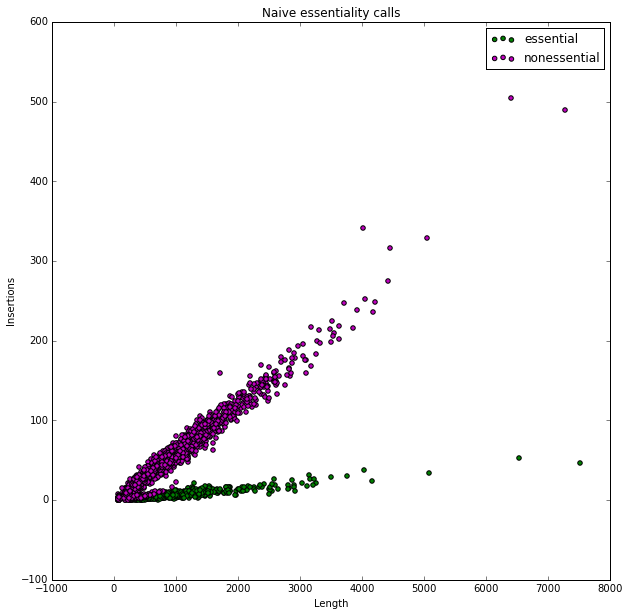

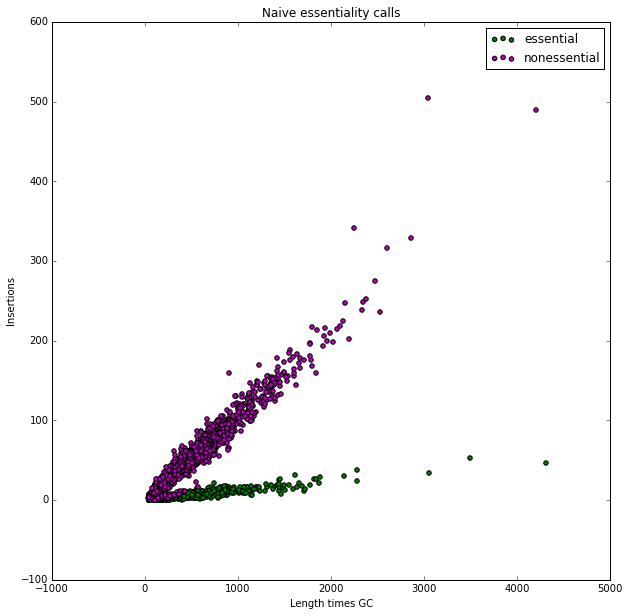

In [17]:
# essentials, nonessentials, regression = callEssentiality(genes_df,len(genome),pool_dropped_df)
callEssentialityFreq(genes_df,len(genome),pool_dropped_df)
genes_df.columns

In [10]:
# tnSeq rep1
pool_f = open("/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/DSJD02HTn1_R1/DSJDo2Htn1_S1_l006_R1_001.pool", "r")
# tnSeq rep2
# pool_f = open("/mnt/59E0-214E/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool", "r")
pool_df = pd.read_table(pool_f)
pool_f.close()
pool_dropped_df=processData(pool_df)

insertion pool length 107254
dropped insertion pool length 102511
only single insertions pool length 53787
unique pos values in dropped 72820
unique pos values in only 1 pos 43192


In [11]:
genes_f = open("/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/Halo/genes.GC", "r")
genes_df = pd.read_table(genes_f)
genes_f.close()
genes_df.columns

Index(['locusId', 'sysName', 'type', 'scaffoldId', 'begin', 'end', 'strand',
       'name', 'desc', 'GC', 'nTA'],
      dtype='object')

Predicted rate of insertion: 0.03968854993987346
percent of genes initially called as essential: 0.23048172757475083
Coeficients(length timesGC content)- [0.0965876]
Intercept: 0.0
Rsquare: 0.8154994294261169


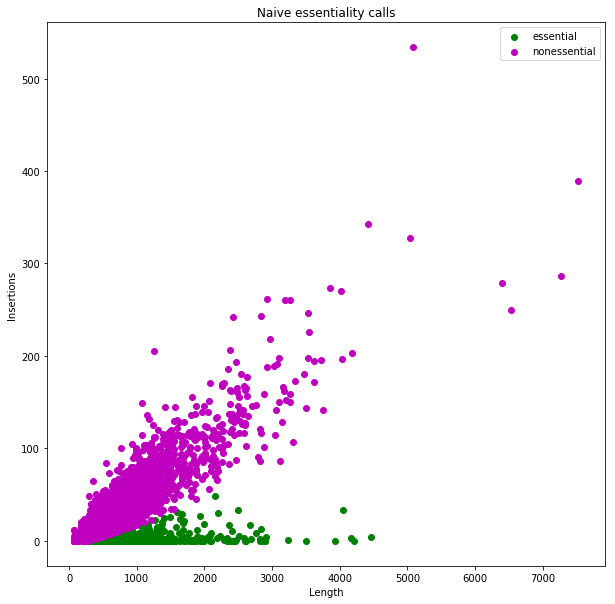

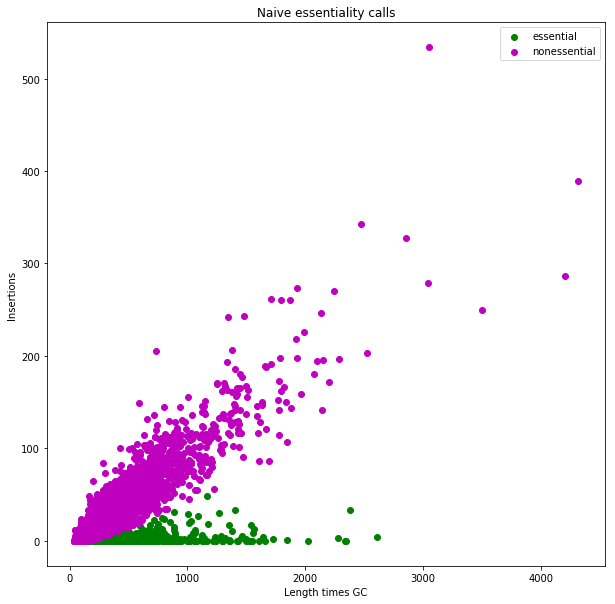

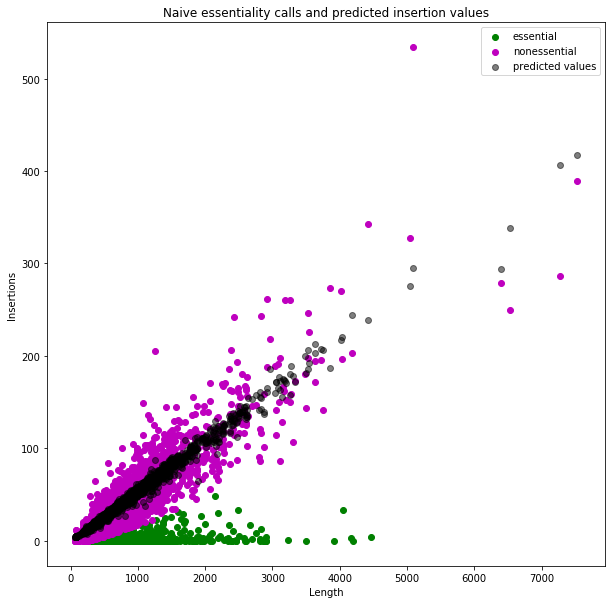

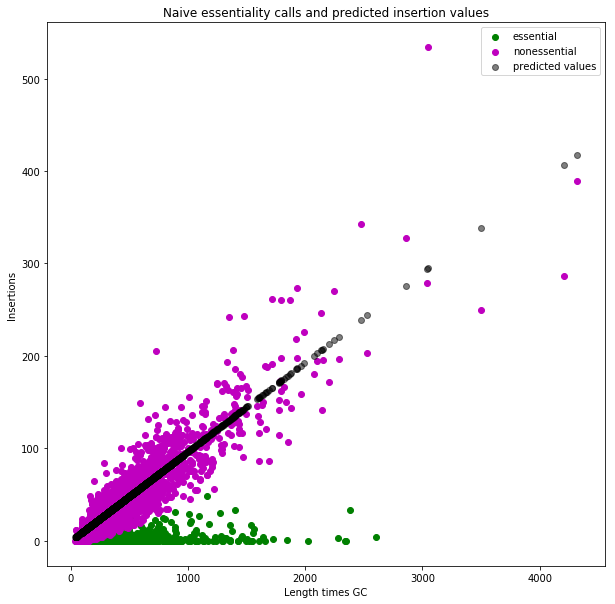

percent of genes called as essential: 0.2703488372093023


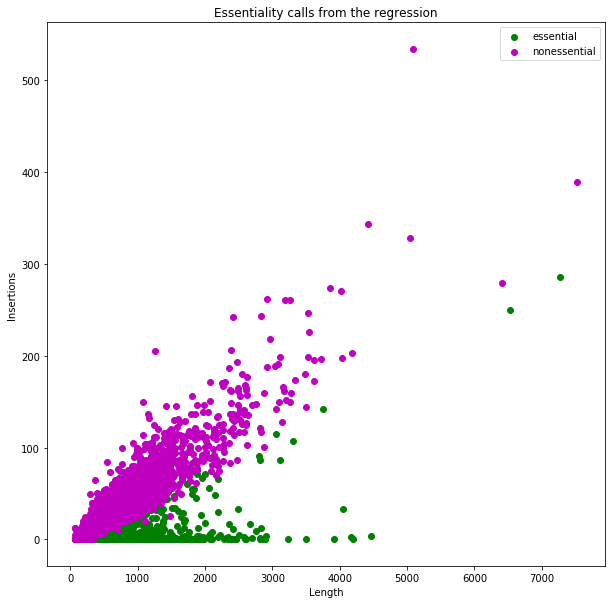

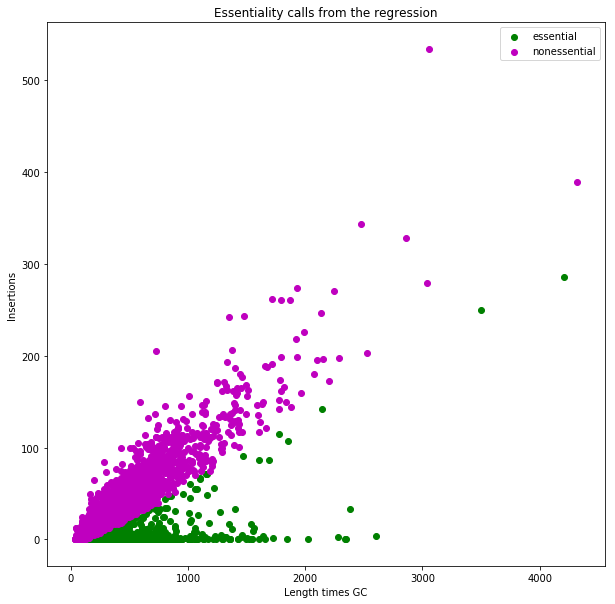

In [12]:
callEssentialityFreq(genes_df,len(genome),pool_dropped_df)
genes_df.to_csv('/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/geneStatsRep1.csv')

In [13]:
# tnSeq rep1
# pool_f = open("/mnt/59E0-214E/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/DSJD02HTn1_R1/DSJDo2Htn1_S1_l006_R1_001.pool", "r")
# tnSeq rep2
pool_f = open("/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool", "r")
pool_df = pd.read_table(pool_f)
pool_f.close()
pool_dropped_df=processData(pool_df)

insertion pool length 101140
dropped insertion pool length 99429
only single insertions pool length 71788
unique pos values in dropped 71143
unique pos values in only 1 pos 55008


In [14]:
genes_f = open("/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/Halo/genes.GC", "r")
genes_df = pd.read_table(genes_f)
genes_f.close()
genes_df.columns

Index(['locusId', 'sysName', 'type', 'scaffoldId', 'begin', 'end', 'strand',
       'name', 'desc', 'GC', 'nTA'],
      dtype='object')

Predicted rate of insertion: 0.03849531105902467
percent of genes initially called as essential: 0.2350498338870432
Coeficients(length timesGC content)- [0.09402901]
Intercept: 0.0
Rsquare: 0.8140022245481067


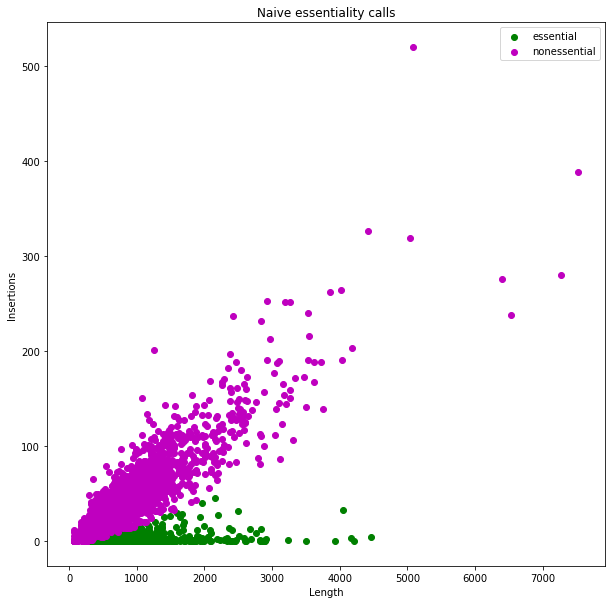

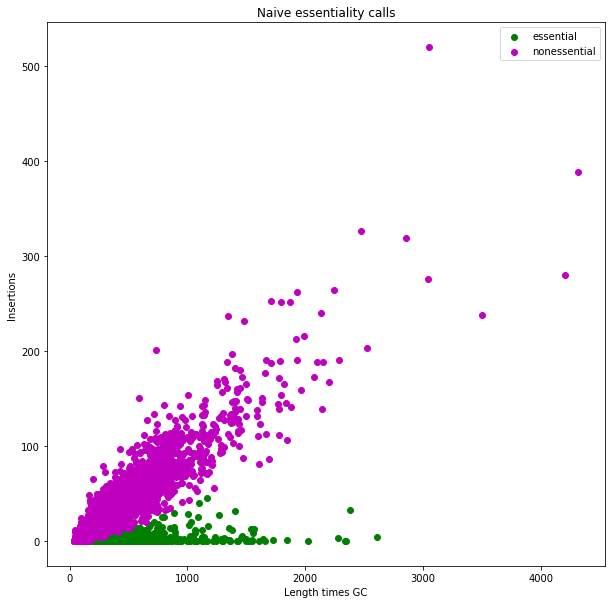

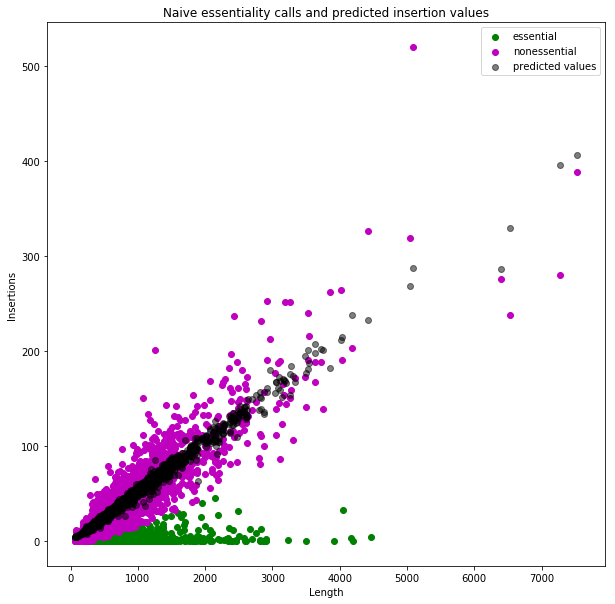

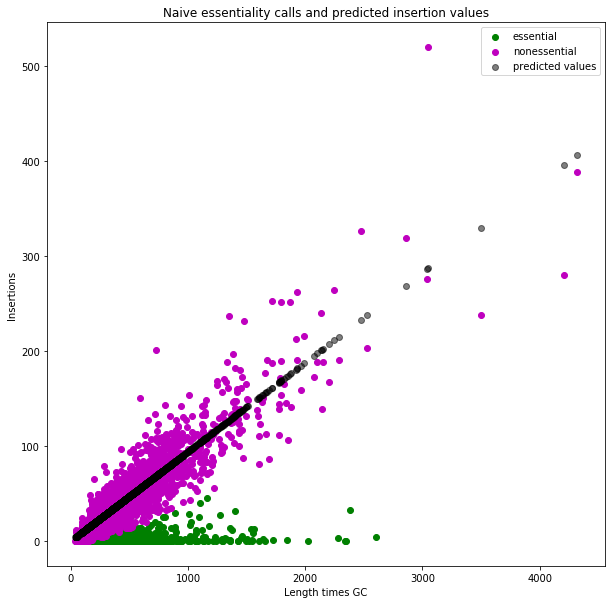

percent of genes called as essential: 0.2707641196013289


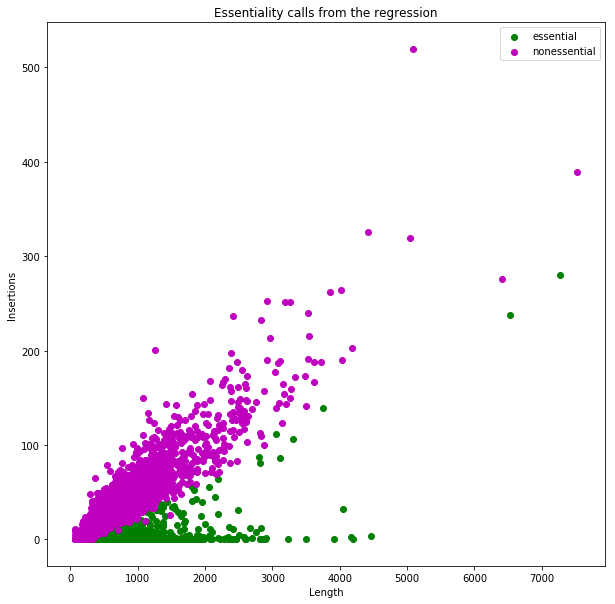

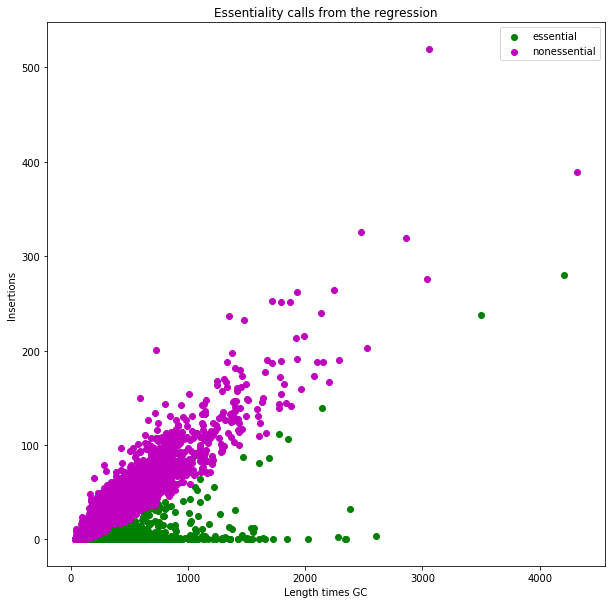

In [15]:
callEssentialityFreq(genes_df,len(genome),pool_dropped_df)
genes_df.to_csv('/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/geneStatsRep2.csv')

In [67]:
min(r1essentials.pvalCorrected)

5.645379772407636e-105

In [68]:
r1EssSet=set(r1essentials.locusId)
r2EssSet=set(r2essentials.locusId)
print('Number of genes called as essential in only one replicate: %s'%
      len(r1EssSet.symmetric_difference(r2EssSet)))

Number of genes called as essential in only one replicate: 21


In [69]:
print('Number of genes called as essential in only rep 2: %s'%
      len(r2essentials[r2essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]))
print('Number of  genes called as essential in rep 1 called nonessential in rep 2: %s'%
      len(r2nonessentials[r2nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]))


Number of genes called as essential in only rep 2: 11
Number of  genes called as essential in rep 1 called nonessential in rep 2: 10


In [70]:
print('Number of genes called as essential in only rep 1: %s'%
      len(r1essentials[r1essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]))
print('Number of  genes called as essential in rep 2 called nonessential in rep 1: %s'%
      len(r1nonessentials[r1nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]))


Number of genes called as essential in only rep 1: 10
Number of  genes called as essential in rep 2 called nonessential in rep 1: 11


In [71]:
genes_df.columns

Index(['locusId', 'sysName', 'type', 'scaffoldId', 'begin', 'end', 'strand',
       'name', 'desc', 'GC', 'nTA', 'pvalInitial', 'pvalCorrected', 'length',
       'inserts', 'lg', 'predictedInsertionRate'],
      dtype='object')

In [72]:
dubEss = r1essentials.merge(r2essentials, how='inner',on=['locusId', 'sysName', 'type', 'scaffoldId', 'begin', 'end', 
                                                          'strand','name', 'desc', 'GC', 'nTA'],suffixes=('_r1','_r2'))
dubEss.to_csv('/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/essentialsFromLenGCAnalysis_bothReps.csv')

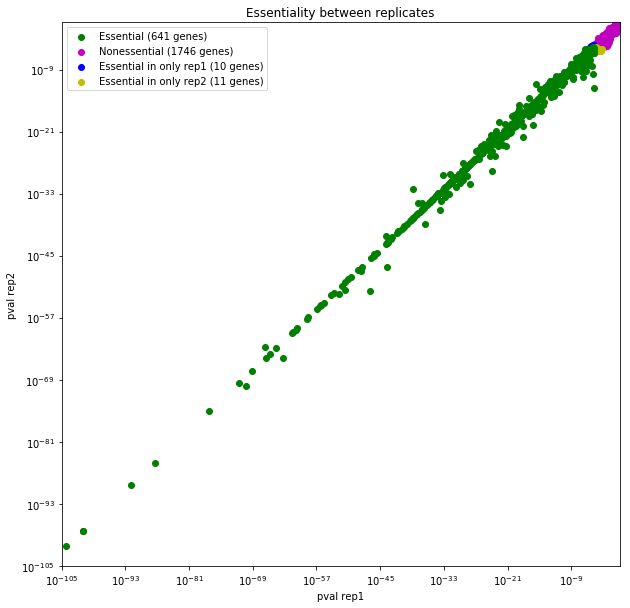

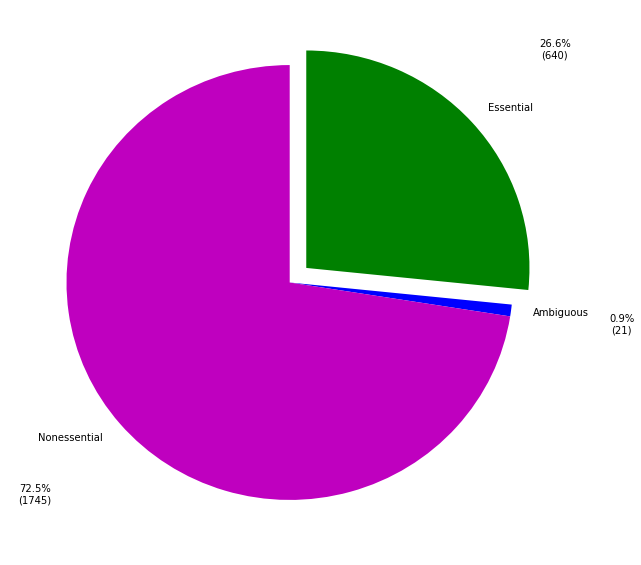

In [91]:
#     plot the pvals between the 2 reps
fig = plt.figure(figsize=(10,10))

# essential in both reps
r1ess = r1essentials[~r1essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r2ess = r2essentials[~r2essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1ess.pvalCorrected, r2ess.pvalCorrected, c='g', label='Essential (%s genes)'%len(r1ess),zorder=10)
ess=len(r1ess)

# nonessential in both reps
r1non = r1nonessentials[~r1nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r2non = r2nonessentials[~r2nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1non.pvalCorrected, r2non.pvalCorrected, c='m', label='Nonessential (%s genes)'%len(r1non),zorder=1)
non=len(r1non)

# essential in 1 not 2
r1ess = r1essentials[r1essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r2non = r2nonessentials[r2nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1ess.pvalCorrected, r2non.pvalCorrected, c='b', label='Essential in only rep1 (%s genes)'%len(r1ess)
            ,zorder=5)
amb=len(r1ess)
# essential in 2 not 1
r2ess = r2essentials[r2essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r1non = r1nonessentials[r1nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1non.pvalCorrected, r2ess.pvalCorrected, c='y', label='Essential in only rep2 (%s genes)'%len(r2ess)
            ,zorder=5)
amb=amb+len(r2ess)

# plt.scatter(neg.length, predictions, c='k', alpha=0.5, label='predicted values')
plt.legend(loc=0)
plt.title('Essentiality between replicates')
plt.ylabel('pval rep2')
plt.xlabel('pval rep1')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10e-106)
plt.ylim(10e-106)
plt.show()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig = plt.figure(figsize=(10,10))
dat=[ess,amb,non]
plt.pie(dat,explode=[0.1,0,0],labels=['Essential','Ambiguous','Nonessential'],colors=['g','b','m'],
        startangle=90,counterclock=False,pctdistance=1.5,autopct=lambda pct: func(pct, dat))
plt.show()

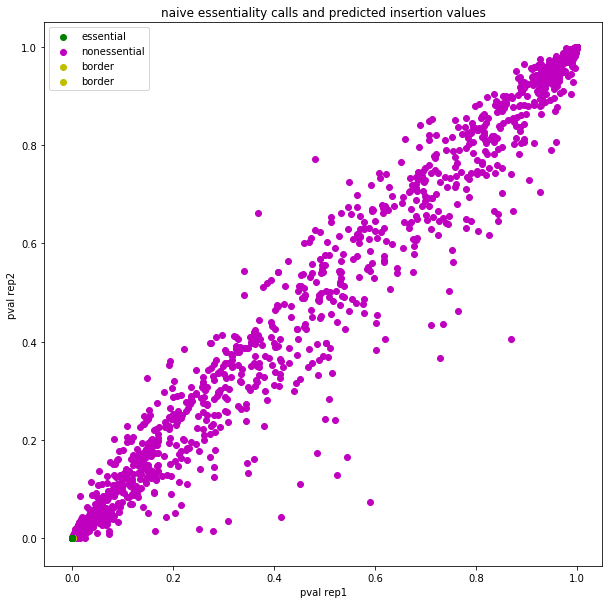

In [173]:
#     plot the pvals between the 2 reps
fig = plt.figure(figsize=(10,10))

# essential in both reps
r1ess = r1essentials[~r1essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r2ess = r2essentials[~r2essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1ess.pvalCorrected, r2ess.pvalCorrected, c='g', label='essential',zorder=10)

# nonessential in both reps
r1non = r1nonessentials[~r1nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r2non = r2nonessentials[~r2nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1non.pvalCorrected, r2non.pvalCorrected, c='m', label='nonessential',zorder=1)

# essential in 1 not 2
r1ess = r1essentials[r1essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r2non = r2nonessentials[r2nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1ess.pvalCorrected, r2non.pvalCorrected, c='y', label='border',zorder=5)

# essential in 2 not 1
r2ess = r2essentials[r2essentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
r1non = r1nonessentials[r1nonessentials.locusId.isin([x for x in r1EssSet.symmetric_difference(r2EssSet)])]
plt.scatter(r1non.pvalCorrected, r2ess.pvalCorrected, c='y', label='border',zorder=5)

# plt.scatter(neg.length, predictions, c='k', alpha=0.5, label='predicted values')
plt.legend(loc=0)
plt.title('naive essentiality calls and predicted insertion values')
plt.ylabel('pval rep2')
plt.xlabel('pval rep1')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10e-106)
# plt.ylim(10e-106)
plt.show()

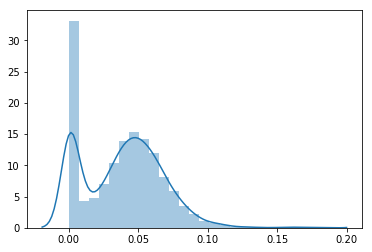

In [119]:
sns.distplot(genes_df.inserts/genes_df.length)

In [120]:
setFromTheMid = genes_df[(genes_df.inserts/genes_df.length>0.048)&(genes_df.inserts/genes_df.length<0.052)]
setFromTheMid

,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,pvalInitial,pvalCorrected,length,inserts,lg,predictedInsertionRate
28,HNEAP_RS00155,HNEAP_RS00155,1,NC_013422.1,38154,38462,+,NaN,BolA family transcriptional regulator,0.5793,4,0.832071,0.344889,308,15,178.4244,0.055953
33,HNEAP_RS00180,HNEAP_RS00180,1,NC_013422.1,42782,43396,-,NaN,DedA family protein,0.5707,11,0.894671,0.282886,614,30,350.4098,0.055123
62,HNEAP_RS00325,HNEAP_RS00325,1,NC_013422.1,73294,74238,+,NaN,acyl-CoA synthetase,0.5831,15,0.963003,0.258847,944,48,550.4464,0.056320
64,HNEAP_RS00335,HNEAP_RS00335,1,NC_013422.1,74834,77248,+,NaN,MMPL domain-containing protein,0.5925,39,0.995206,0.070160,2414,121,1430.2950,0.057228
66,HNEAP_RS00345,HNEAP_RS00345,1,NC_013422.1,78057,79043,+,NaN,2-hydroxyacid dehydrogenase,0.5755,20,0.974466,0.328748,986,51,567.4430,0.055586
81,HNEAP_RS00420,HNEAP_RS00420,1,NC_013422.1,86050,86634,-,NaN,ATPase,0.5504,16,0.934925,0.470743,584,30,321.4336,0.053162
149,HNEAP_RS12090,HNEAP_RS12090,1,NC_013422.1,155248,156309,+,NaN,peptidoglycan-binding lysin domain-containing ...,0.5480,17,0.926717,0.265449,1061,51,581.4280,0.052930
163,HNEAP_RS00825,HNEAP_RS00825,1,NC_013422.1,173038,174135,+,NaN,transaldolase,0.5638,23,0.981414,0.389870,1097,57,618.4886,0.054456
176,HNEAP_RS00890,HNEAP_RS00890,1,NC_013422.1,185244,185927,+,NaN,ArsR family transcriptional regulator,0.5950,13,0.945349,0.273706,683,35,406.3850,0.057470
182,HNEAP_RS00920,HNEAP_RS00920,1,NC_013422.1,191745,193094,+,NaN,hypothetical protein,0.5689,29,0.970895,0.216193,1349,67,767.4461,0.054949


In [121]:
setFromTheBot = genes_df[genes_df.inserts/genes_df.length<0.002]
setFromTheBot

,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,pvalInitial,pvalCorrected,length,inserts,lg,predictedInsertionRate
0,HNEAP_RS00015,HNEAP_RS00015,1,NC_013422.1,159,1559,+,NaN,chromosomal replication initiator protein DnaA,0.5353,30,4.124691e-22,1.575287e-29,1400,2,749.4200,0.051703
1,HNEAP_RS00020,HNEAP_RS00020,1,NC_013422.1,1623,2735,+,NaN,DNA polymerase III subunit beta,0.5346,22,3.051187e-17,4.715199e-23,1112,2,594.4752,0.051636
3,HNEAP_RS00030,HNEAP_RS00030,1,NC_013422.1,4029,6482,+,NaN,DNA topoisomerase (ATP-hydrolyzing) subunit B,0.5534,49,7.192812e-44,3.008702e-59,2453,0,1357.4902,0.053452
32,HNEAP_RS00175,HNEAP_RS00175,1,NC_013422.1,42146,42775,-,NaN,guanylate kinase,0.5794,9,8.653970e-12,1.854102e-16,629,0,364.4426,0.055963
42,HNEAP_RS00225,HNEAP_RS00225,1,NC_013422.1,53431,54390,+,NaN,thioredoxin-disulfide reductase,0.5594,13,1.358973e-17,7.343566e-24,959,0,536.4646,0.054031
48,HNEAP_RS00255,HNEAP_RS00255,1,NC_013422.1,58846,60408,+,NaN,bifunctional phosphoribosylaminoimidazolecarbo...,0.6065,19,3.370632e-28,1.120550e-41,1562,0,947.3530,0.058580
83,HNEAP_RS00430,HNEAP_RS00430,1,NC_013422.1,87840,88211,-,NaN,VOC family protein,0.4194,16,2.984639e-07,2.173718e-07,371,0,155.5974,0.040509
98,HNEAP_RS00500,HNEAP_RS00500,1,NC_013422.1,99908,102244,+,NaN,Fe(2+) transporter permease subunit FeoB,0.5627,41,1.269773e-36,8.342758e-52,2336,3,1314.4672,0.054350
103,HNEAP_RS00525,HNEAP_RS00525,1,NC_013422.1,104375,104971,+,NaN,imidazoleglycerol-phosphate dehydratase,0.5695,11,3.293183e-11,2.267464e-15,596,0,339.4220,0.055007
104,HNEAP_RS00530,HNEAP_RS00530,1,NC_013422.1,104974,105624,+,NaN,imidazole glycerol phosphate synthase subunit ...,0.5822,14,3.697172e-12,4.592221e-17,650,0,378.4300,0.056233


In [122]:
pct2countOfMid=[0]*50
for gene in setFromTheMid.itertuples():
#     check that this behavior is correct
    for i in range(50):
        if gene.strand == '+':
            start = gene.begin + gene.length*0.02*i
            end = gene.begin + gene.length*0.02*(i+1)
        else:
            start = gene.end - gene.length*0.02*i
            end = gene.end - gene.length*0.02*(i+1)
#     calculate important charecteristics for the genes
        pct2countOfMid[i] += len(pool_dropped_df[(pool_dropped_df.pos>start) & (pool_dropped_df.pos<end)])
pct2countOfMid=pct2countOfMid/sum(pct2countOfMid)
pct2countOfMid

array([0.01664219, 0.02716593, 0.01786588, 0.01517376, 0.02006853,
       0.02251591, 0.02276065, 0.0237396 , 0.01762115, 0.02031326,
       0.01615272, 0.02325012, 0.01933431, 0.020558  , 0.02129222,
       0.0237396 , 0.02545277, 0.02178169, 0.01786588, 0.01737641,
       0.01615272, 0.02692119, 0.020558  , 0.01786588, 0.020558  ,
       0.02496329, 0.01737641, 0.02153696, 0.02300538, 0.01321586,
       0.01786588, 0.020558  , 0.0154185 , 0.01517376, 0.02153696,
       0.02961331, 0.01884484, 0.01908957, 0.01713167, 0.02251591,
       0.01786588, 0.01517376, 0.02227117, 0.0237396 , 0.02276065,
       0.01468429, 0.01517376, 0.01713167, 0.02447381, 0.01615272])

In [123]:
pct2countOfBot=[0]*50
for gene in setFromTheBot.itertuples():
    for i in range(50):
#     check that this behavior is correct
        if gene.strand == '+':
            start = gene.begin + gene.length*0.02*i
            end = gene.begin + gene.length*0.02*(i+1)
        else:
            start = gene.end - gene.length*0.02*i
            end = gene.end - gene.length*0.02*(i+1)
#     calculate important charecteristics for the genes
        pct2countOfBot[i] += len(pool_dropped_df[(pool_dropped_df.pos>start) & (pool_dropped_df.pos<end)])
        
pct2countOfBot=pct2countOfBot/sum(pct2countOfBot)
pct2countOfBot

array([0.10784314, 0.05882353, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00980392, 0.        , 0.        , 0.        ,
       0.        , 0.00980392, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00980392, 0.02941176,
       0.02941176, 0.01960784, 0.05882353, 0.16666667, 0.5       ])

In [124]:
pct2countOfTot=[0]*50
for gene in genes_df.itertuples():
    for i in range(50):
#     check that this behavior is correct
        if gene.strand == '+':
            start = gene.begin + gene.length*0.02*i
            end = gene.begin + gene.length*0.02*(i+1)
        else:
            start = gene.end - gene.length*0.02*i
            end = gene.end - gene.length*0.02*(i+1)
#     calculate important charecteristics for the genes
        pct2countOfTot[i] += len(pool_dropped_df[(pool_dropped_df.pos>start) & (pool_dropped_df.pos<end)])
        
pct2countOfTot=pct2countOfTot/sum(pct2countOfTot)
pct2countOfTot

array([0.017827  , 0.0198753 , 0.0224188 , 0.01800707, 0.01969523,
       0.01924505, 0.02176604, 0.02151845, 0.01879488, 0.02131587,
       0.02050555, 0.01978527, 0.02120332, 0.01832219, 0.01985279,
       0.020393  , 0.02181106, 0.01940262, 0.02001035, 0.02005537,
       0.01913251, 0.01847975, 0.01841223, 0.01980777, 0.02048304,
       0.01872735, 0.01838972, 0.02109078, 0.01814212, 0.02104576,
       0.01818714, 0.02084318, 0.02230626, 0.0193576 , 0.01913251,
       0.0193576 , 0.01929007, 0.02023544, 0.01784951, 0.02028046,
       0.01938011, 0.01915502, 0.01992032, 0.02048304, 0.02068562,
       0.0196277 , 0.02352173, 0.01913251, 0.02228375, 0.02345421])

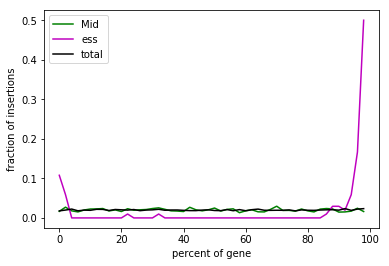

In [125]:
# was wrong... should double check to ensure that I have corrctly compensated for gene location
plt.plot(range(0,100,2),pct2countOfMid,c='g',label='Mid')
plt.plot(range(0,100,2),pct2countOfBot,c='m',label='ess')
plt.plot(range(0,100,2),pct2countOfTot,c='k',label='total')
plt.legend(loc=0)
plt.xlabel('percent of gene')
plt.ylabel('fraction of insertions')
plt.show()

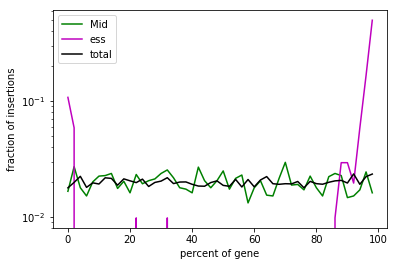

In [126]:
# was wrong... should double check to ensure that I have corrctly compensated for gene location
plt.plot(range(0,100,2),pct2countOfMid,c='g',label='Mid')
plt.plot(range(0,100,2),pct2countOfBot,c='m',label='ess')
plt.plot(range(0,100,2),pct2countOfTot,c='k',label='total')
plt.legend(loc=0)
plt.yscale('log')
plt.xlabel('percent of gene')
plt.ylabel('fraction of insertions')
plt.show()

In [39]:
len(setFromTheBot[setFromTheBot.inserts>0])

144

In [40]:
essentials[essentials.inserts>200]

,locusId,sysName,type,scaffoldId,begin,end,strand,name,desc,GC,nTA,pvalInitial,pvalCorrected,length,inserts,predictedInsertionRate
367,HNEAP_RS01850,HNEAP_RS01850,1,NC_013422.1,378823,386097,-,NaN,hypothetical protein,0.5783,140,0.451161,1.662259e-09,7274,286,0.054396
514,HNEAP_RS02600,HNEAP_RS02600,1,NC_013422.1,549930,556457,+,NaN,signal transduction histidine kinase,0.5363,88,0.296320,9.935729e-10,6527,250,0.054392


In [41]:
pct2Wierd=[0]*50
for gene in essentials[essentials.inserts>200].itertuples():
    for i in range(50):
#     check that this behavior is correct
        if gene.strand == '+':
            start = gene.begin + gene.length*0.02*i
            end = gene.begin + gene.length*0.02*(i+1)
        else:
            start = gene.end - gene.length*0.02*i
            end = gene.end - gene.length*0.02*(i+1)
#     calculate important charecteristics for the genes
        pct2Wierd[i] += len(pool_dropped_df[(pool_dropped_df.pos>start) & (pool_dropped_df.pos<end)])
        
pct2Wierd=pct2Wierd/sum(pct2Wierd)
pct2Wierd

array([0.028, 0.056, 0.016, 0.   , 0.012, 0.02 , 0.02 , 0.024, 0.008,
       0.008, 0.004, 0.012, 0.024, 0.008, 0.02 , 0.016, 0.044, 0.012,
       0.02 , 0.02 , 0.016, 0.028, 0.016, 0.016, 0.028, 0.   , 0.012,
       0.064, 0.032, 0.004, 0.004, 0.008, 0.028, 0.048, 0.016, 0.012,
       0.   , 0.032, 0.012, 0.024, 0.016, 0.008, 0.02 , 0.012, 0.032,
       0.028, 0.036, 0.008, 0.012, 0.056])

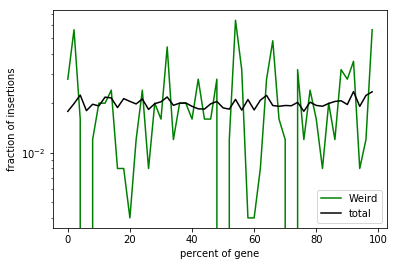

In [42]:
plt.plot(range(0,100,2),pct2Wierd,c='g',label='Weird')
plt.plot(range(0,100,2),pct2countOfTot,c='k',label='total')
plt.legend(loc=0)
plt.yscale('log')
plt.xlabel('percent of gene')
plt.ylabel('fraction of insertions')
plt.show()